# Analyze models and compare them to baseline models based on simple physicochemistry

In [1]:
import stylia
import collections
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression as Regression

In [115]:
physchem = pd.read_csv("../results/complex_vs_simple/physchem.csv")

In [2]:
complex_vs_simple_dir = os.path.join("..", "results", "complex_vs_simple")

hits = pd.read_csv("../data/screening_hits.tsv", sep="\t")
fid_prom = collections.defaultdict(int)
for r in list(hits["FragID"]):
    fid_prom[r] += 1

aucs = []
R = None
for l in os.listdir(complex_vs_simple_dir):
    if "_" not in l:
        continue
    if "promiscuity" not in l:
        continue
    col = l.rstrip(".csv")
    d = pd.read_csv(os.path.join(complex_vs_simple_dir, l))
    prom = []
    for fid in list(d["fid"]):
        if fid in fid_prom:
            prom += [fid_prom[fid]]
        else:
            prom += [0]
    d["prom"] = prom
    if R is None:
        R = [
            list(d["fid"]),
            list(d["logp"]),
            list(d["csp2"]),
            list(d["prom"]),
            list(d["y"]),
            list(d["y_hat"])
        ]
        columns = [
            "fid",
            "logp",
            "csp2",
            "prom",
            col,
            col+"_hat"
        ]
    else:
        R += [list(d["y"])]
        R += [list(d["y_hat"])]
        columns += [col, col+"_hat"]
    aucs += [roc_auc_score(d["y"], d["y_hat"])]

def transpose(matrix):
    return [list(row) for row in zip(*matrix)]

d = pd.DataFrame(transpose(R), columns=columns)
X = np.array(d[[x for x in list(d.columns) if x.startswith("promiscuity_") and x.endswith("_hat")]])

def regression_prediction(X, y):
    X = np.array(X)
    y = np.array(y)
    idxs = [i for i in range(X.shape[0])]
    y_hat = []
    for idx in idxs:
        idxs_train = [i for i in idxs if i != idx]
        idxs_test = [idx]
        lr = Regression()
        lr.fit(X[idxs_train], y[idxs_train])
        y_hat += list(lr.predict(X[idxs_test]))
    return y_hat

d["prom_reg_hat"] = regression_prediction(X, d["prom"])

weights = np.clip(aucs, 0.5, 1)
weights = weights / np.sum(weights)
d["prom_avg_hat"] = np.average(X, axis=1, weights=weights)
d["prom_sum_hat"] = np.sum(X, axis=1)

sig = pd.read_csv("../data/fragment_signatures.csv")

d = pd.concat([d, sig[[c for c in list(sig.columns) if c.startswith("signature_")]]], axis=1)

In [118]:
d

,fid,logp,csp2,prom,promiscuity_fxp2_pxf0,promiscuity_fxp2_pxf0_hat,promiscuity_fxp2_pxf1,promiscuity_fxp2_pxf1_hat,promiscuity_fxp2_pxf2,promiscuity_fxp2_pxf2_hat,...,signature_0,signature_1,signature_2,signature_3,signature_4,signature_5,signature_6,signature_7,signature_8,signature_9
0,C001,3.46930,7,91,1,0.936446,0,0.905581,0,0.477953,...,0,0,0,0,0,0,0,0,0,0
1,C002,2.12232,10,14,0,0.621231,0,0.459718,0,0.045822,...,0,0,0,0,1,0,0,0,1,0
2,C003,3.17886,10,93,0,0.548159,0,0.499813,0,0.038458,...,0,0,0,0,0,0,0,0,0,0
3,C004,4.03440,8,288,1,0.954695,1,0.837444,0,0.509311,...,0,0,0,0,0,0,0,0,1,0
4,C006,2.57990,3,8,0,0.624419,0,0.256677,0,0.057379,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,C429,4.65142,10,277,1,0.932873,1,0.751753,1,0.248928,...,0,0,0,0,0,0,0,0,0,0
403,C430,2.85670,9,88,1,0.753761,0,0.372330,0,0.175206,...,0,1,0,0,0,0,0,0,0,0
404,C431,4.20610,9,329,1,0.926776,1,0.871716,1,0.116965,...,0,0,0,0,0,0,0,0,0,0
405,C432,1.35930,5,17,0,0.117118,0,0.021022,0,0.033342,...,0,0,0,0,0,0,0,0,0,0


In [119]:
for col in list(d.columns):
    if col.startswith("signature_"):
        y = d[col]
        y_hat = d["logp"]
        print(col, round(roc_auc_score(y, y_hat), 2))

signature_0 0.82
signature_1 0.44
signature_2 0.43
signature_3 0.32
signature_4 0.59
signature_5 0.27
signature_6 0.82
signature_7 0.6
signature_8 0.47
signature_9 0.81


In [155]:
R = []
for col in list(d.columns):
    if col.startswith("signature_"):
        y = d[col]
        for pcol in list(physchem.columns)[3:]:
            y_hat = np.array(physchem[pcol])
            auroc = roc_auc_score(y, y_hat)
            if auroc > 0.7:
                print(col, round(auroc, 2), pcol)
                R += [[col, pcol, auroc]]
            else:
                auroc = roc_auc_score(y, -y_hat)
                if auroc > 0.7:
                    print(col, round(auroc, 2), pcol)
                    R += [[col, pcol, auroc]]

ds = pd.DataFrame(R, columns=["signature", "property", "auroc"])

ds[ds["signature"] == "signature_9"]

signature_0 0.82 MolLogP
signature_0 0.71 NumAromaticCarbocycles
signature_0 0.71 NumHAcceptors
signature_0 0.71 SMR_VSA6
signature_0 0.72 SMR_VSA7
signature_0 0.78 SlogP_VSA2
signature_0 0.71 VSA_EState2
signature_0 0.71 VSA_EState6
signature_0 0.71 fr_benzene
signature_2 0.77 BertzCT
signature_2 0.71 EState_VSA1
signature_2 0.73 EState_VSA3
signature_2 0.77 EState_VSA4
signature_2 0.78 FractionCSP3
signature_2 0.75 HallKierAlpha
signature_2 0.73 MinEStateIndex
signature_2 0.7 NumAliphaticHeterocycles
signature_2 0.73 NumAromaticRings
signature_2 0.7 NumHeteroatoms
signature_2 0.71 NumSaturatedHeterocycles
signature_2 0.75 SMR_VSA10
signature_2 0.81 SMR_VSA6
signature_2 0.76 SlogP_VSA2
signature_2 0.8 TPSA
signature_2 0.74 VSA_EState8
signature_2 0.73 VSA_EState9
signature_4 0.71 FractionCSP3
signature_4 0.73 HallKierAlpha
signature_5 0.73 MolLogP
signature_5 0.72 NumAliphaticHeterocycles
signature_5 0.73 NumRotatableBonds
signature_6 0.82 MolLogP
signature_6 0.83 NOCount
signature_6 

,signature,property,auroc
41,signature_9,MolLogP,0.805256
42,signature_9,NOCount,0.719901
43,signature_9,SlogP_VSA2,0.774483


In [126]:
d["csp2"].min()

1

12


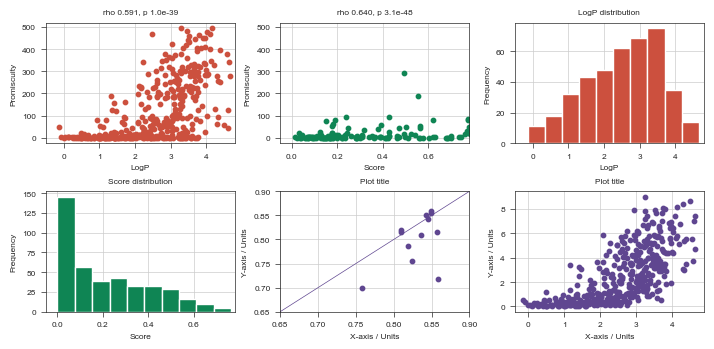

In [3]:
from stylia.colors.colors import NamedColors

def prom_correlation_plot(ax, col):
    if col == "logp":
        xlabel = "LogP"
        xlim = (-0.5, 4.8)
        color = NamedColors().red
    elif col == "csp2":
        xlabel = "Csp2"
        xlim = (0,16)
        color = NamedColors().blue
    else:
        xlabel = "Score"
        xlim = (-0.05, 0.78)
        color = NamedColors().green
    y = list(d["prom"])
    x = list(d[col])
    ax.scatter(x, y, color=color)
    rho, pval = pearsonr(x,y)
    title = "rho {0:.3f}, p {1:.1e}".format(rho, pval)
    stylia.label(ax=ax, title=title, xlabel=xlabel, ylabel="Promiscuity")
    ax.set_xlim(xlim)

def histogram(ax, col):
    if col == "logp":
        xlabel = "LogP"
        xlim = (-0.5, 4.8)
        color = NamedColors().red
    elif col == "csp2":
        xlabel = "Csp2"
        xlim = (0,16)
        color = NamedColors().blue
    else:
        xlabel = "Score"
        xlim = (-0.05, 0.78)
        color = NamedColors().green
    ax.hist(d[col], color=color)
    ax.set_xlim(xlim)
    stylia.label(ax, title="{0} distribution".format(xlabel), xlabel=xlabel, ylabel="Frequency")

def prediction_vs_property_plot(ax, col):
    if col == "logp":
        xlabel = "LogP"
        xlim = (-0.5, 4.8)
        color = NamedColors().red
    elif col == "csp2":
        xlabel = "Csp2"
        xlim = (0,16)
        color = NamedColors().blue
    else:
        xlabel = "Score"
        xlim = (-0.5, 10.5)
        color = NamedColors().green
    ax.scatter(d[col], d["prom_sum_hat"], color=color)
    ax.set_xlim(xlim)
    ax.set_ylim(-0.5, 10.5)
    stylia.label(ax=ax, title="{0} vs Score".format(xlabel), xlabel=xlabel, ylabel="Score (sum promiscuity)")

def aurocs_comparison_plot(ax):
    logp = list(d["logp"])
    aurocs_x = []
    aurocs_y = []
    for col in list(d.columns):
        if col.startswith("promiscuity_") and not "_hat" in col:
            y = list(d[col])
            y_hat = list(d[col+"_hat"])
            auroc_x = roc_auc_score(y, logp)
            auroc_y = roc_auc_score(y, y_hat)
            aurocs_x += [auroc_x]
            aurocs_y += [auroc_y]
    ax.scatter(aurocs_x, aurocs_y)
    print(len(aurocs_x))
    ax.plot([0,1], [0,1])
    ax.set_xlim(0.65, 0.90)
    ax.set_ylim(0.65, 0.90)
            
fig, axs = stylia.create_figure(2,3)
ax = axs.next()
prom_correlation_plot(ax, "logp")
ax = axs.next()
prom_correlation_plot(ax, "prom_sum_hat")
ax = axs.next()
histogram(ax, "logp")
ax = axs.next()
histogram(ax, "prom_avg_hat")
ax = axs.next()
aurocs_comparison_plot(ax)
ax = axs.next()
ax.scatter(d["logp"], d["prom_sum_hat"])
stylia.label("")
plt.tight_layout()

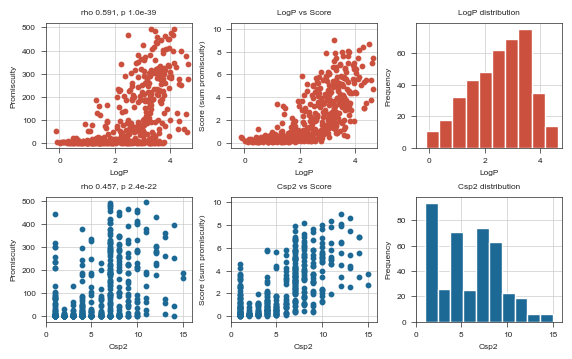

In [146]:
fig, axs = stylia.create_figure(2, 3, width=stylia.TWO_COLUMNS_WIDTH*0.8, height=stylia.TWO_COLUMNS_WIDTH*0.5)
ax = axs.next()
prom_correlation_plot(ax, "logp")
ax = axs.next()
prediction_vs_property_plot(ax, "logp")
ax = axs.next()
histogram(ax, "logp")
ax = axs.next()
prom_correlation_plot(ax, "csp2")
ax = axs.next()
prediction_vs_property_plot(ax, "csp2")
ax = axs.next()
histogram(ax, "csp2")
plt.tight_layout()

stylia.save_figure("../assets/RebuttalFigure_Promiscuity_Csp2.png")
stylia.save_figure("../assets/RebuttalFigure_Promiscuity_Csp2.pdf")

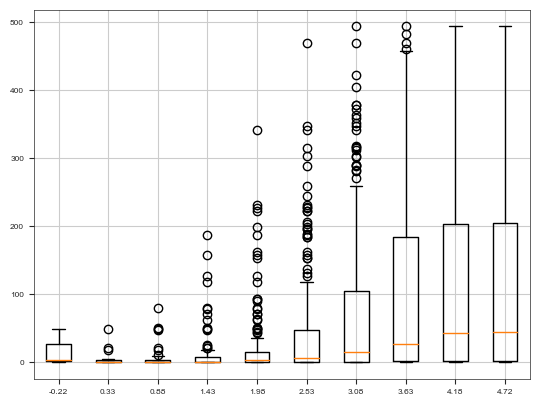

In [89]:
def generate_intervals(start, end, num_intervals):
    if num_intervals <= 0:
        raise ValueError("Number of intervals must be positive")
    
    step = (end - start) / num_intervals
    intervals = [(start + i * step, start + (i + 1) * step) for i in range(num_intervals)]

    return intervals

def logp_boxplot(ax):
    intervals = generate_intervals(-0.5, 5, 10)
    R = []
    for interval in intervals:
        d_ = d[d["logp"] >= interval[0]]
        d_ = d[d["logp"] < interval[1]]
        vals = list(d_["prom"])
        R += [vals]
    ax.boxplot(R)
    ax.set_xticklabels([round(np.mean(x),2) for x in intervals])

fig, ax = plt.subplots(1,1)
logp_boxplot(ax)

In [73]:


# Example usage
start_value = float(input("Enter the start value: "))
end_value = float(input("Enter the end value: "))
num_intervals = int(input("Enter the number of intervals: "))


intervals = generate_intervals(start_value, end_value, num_intervals)

intervals

[(2.0, 2.1),
 (2.1, 2.2),
 (2.2, 2.3),
 (2.3, 2.4),
 (2.4, 2.5),
 (2.5, 2.6),
 (2.6, 2.7),
 (2.7, 2.8),
 (2.8, 2.9),
 (2.9, 3.0)]

In [81]:
df = pd.read_csv("../data/specificity_pxf.csv")

In [106]:
d = pd.read_csv("../results/complex_vs_simple/specificity_pxf2.csv")

In [111]:
roc_auc_score(d["y"], d["y_hat"])

0.8238068500842223

In [107]:
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem
df["logp"] = [MolLogP(Chem.MolFromSmiles(smi)) for smi in list(df["smiles"])]

In [109]:
roc_auc_score(df["specificity_pxf2"], -np.array(df["y_hat"]))

KeyError: 'y_hat'

In [253]:
def sliding_window_variability(y_hat, y, window_size):
    import numpy as np

    if len(y_hat) != len(y):
        raise ValueError("y_hat and y must be of the same length.")

    if window_size <= 0:
        raise ValueError("Window size must be positive.")

    if window_size > len(y_hat):
        raise ValueError("Window size must be less than or equal to the length of the data.")

    paired = sorted(zip(y_hat, y))
    y_hat = [y_[0] for y_ in paired]
    y = [y_[1] for y_ in paired]

    variability = []
    for i in range(len(y_hat) - window_size + 1):
        window_y = y[i:i + window_size]
        variability.append(np.std(window_y))  # or np.std(window_y) for standard deviation

    return variability


window_size = 50

variability = sliding_window_variability(d["prom_reg_hat"], d["prom"], window_size)
print(variability)


[16.42399464198646, 16.408887835560336, 16.39366950990534, 16.33724578991208, 16.327510526715336, 16.353641796248322, 19.145015016969822, 19.118838876877437, 19.110667178306468, 19.494614640972003, 15.373236484228036, 18.057785024747638, 18.105568204284562, 18.096408483453285, 18.117185211836855, 18.117185211836855, 18.093092604637828, 18.05796223276591, 18.065038056976245, 18.167839717478795, 18.167839717478795, 18.184784848878472, 18.184784848878472, 16.676462454609492, 16.687192693799638, 16.67790154665748, 16.68239790917361, 16.69166258944866, 16.725597149279903, 17.967092140911394, 17.949094684690927, 21.474161217612203, 21.479441333517034, 21.438283513378586, 21.438283513378586, 21.438283513378586, 21.464212074986587, 21.464212074986587, 21.464212074986587, 21.41677846922828, 21.37942936563088, 21.317495162424688, 21.334675999414664, 20.838051732347726, 20.995199451303147, 20.980190656903, 21.000085714110785, 21.010473578670233, 21.005951537600005, 20.956994059263366, 20.96759404

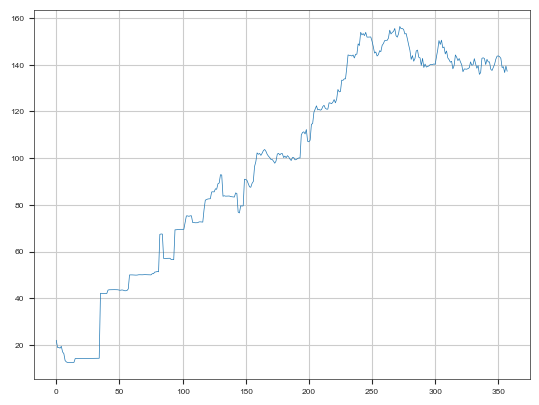

In [241]:
plt.plot(variability)

In [188]:
from sklearn.metrics import precision_recall_curve

0.6242737754356774

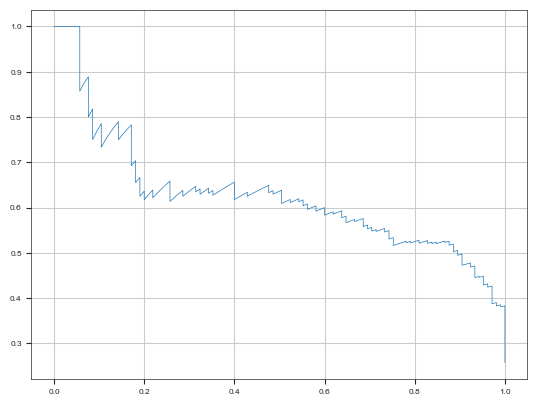

In [273]:
fpr, tpr, _ = precision_recall_curve(d["promiscuity_pxf0"], d["promiscuity_pxf0_hat"])
plt.plot(tpr, fpr)
auc(tpr, fpr)

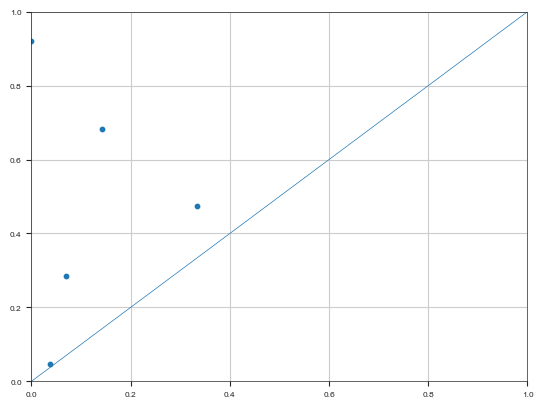

In [180]:
from sklearn.calibration import calibration_curve

x, y = calibration_curve(d["promiscuity_pxf2"], d["promiscuity_pxf2_hat"]/np.max(d["promiscuity_pxf2_hat"]), n_bins=5)
plt.scatter(x,y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1], [0,1])

In [ ]:
from sklearn.calibration import calibration_curve

x, y = calibration_curve(d["promiscuity_pxf0"], d["logp"], n_bins=5)
plt.scatter(x,y)

In [158]:
d

,fid,logp,csp2,prom,promiscuity_pxf0,promiscuity_pxf0_hat,promiscuity_pxf1,promiscuity_pxf1_hat,promiscuity_pxf2,promiscuity_pxf2_hat,promiscuity_fxp0_pxf0,promiscuity_fxp0_pxf0_hat,promiscuity_fxp0_pxf1,promiscuity_fxp0_pxf1_hat,prom_lr_hat,prom_avg_hat
0,C001,3.46930,7,91,0,0.741166,0,0.594716,0,0.069736,0,0.758380,0,0.537187,283.799763,0.553705
1,C002,2.12232,10,14,0,0.226607,0,0.044745,0,0.018708,0,0.067628,0,0.124244,77.531148,0.099439
2,C003,3.17886,10,93,0,0.083453,0,0.044700,0,0.038084,1,0.125325,1,0.052682,64.387480,0.069898
3,C004,4.03440,8,288,1,0.787384,0,0.061427,0,0.004660,1,0.860840,1,0.351793,261.855666,0.427844
4,C006,2.57990,3,8,0,0.143398,0,0.066741,0,0.020218,0,0.118502,0,0.107875,72.345750,0.093514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,C429,4.65142,10,277,1,0.484516,0,0.057109,0,0.056383,1,0.696066,0,0.259443,197.351819,0.319363
403,C430,2.85670,9,88,0,0.338531,0,0.154690,0,0.012154,0,0.307429,0,0.342624,127.561523,0.236786
404,C431,4.20610,9,329,1,0.623060,1,0.086901,0,0.033024,1,0.521513,1,0.435396,192.376800,0.349923
405,C432,1.35930,5,17,0,0.049199,0,0.055690,0,0.027849,0,0.055982,0,0.058745,50.163854,0.049944


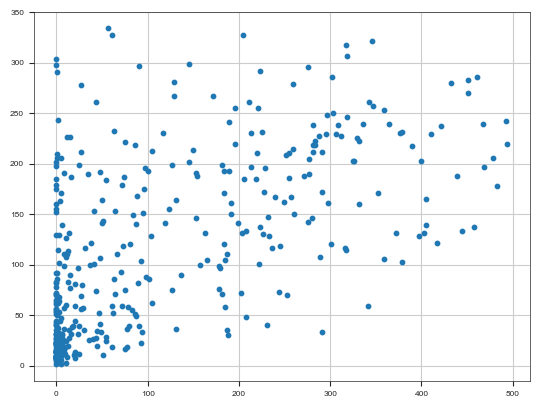

In [15]:
plt.scatter(d["prom"], d["prom_reg_hat"])

In [289]:
from scipy.stats import pearsonr, spearmanr

spearmanr(d[d["prom"] < 100]["prom"], d[d["prom"] < 100]["logp"])

SpearmanrResult(correlation=0.34954395547293243, pvalue=8.462176067203905e-09)

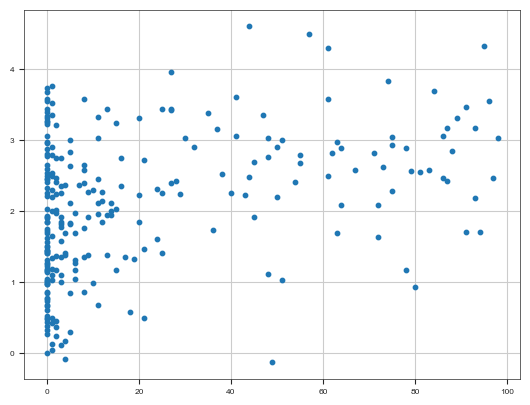

In [290]:
plt.scatter(d[d["prom"] < 100]["prom"], d[d["prom"] < 100]["logp"])

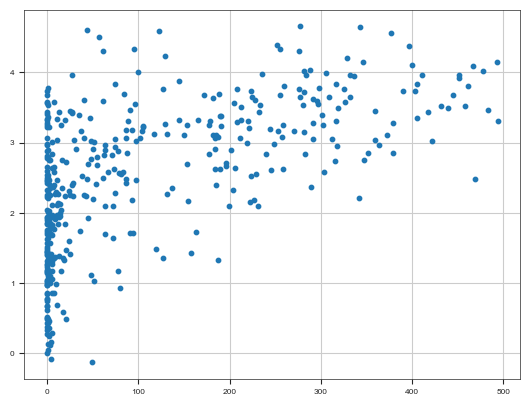

In [291]:
plt.scatter(d["prom"], d["logp"])

In [77]:
d

,fid,smiles,logp,csp2,y,y_hat,prom
0,C001,C#CCCC1(CCC(=O)N2C3CCC2CC(O)(Cc2ccccc2)C3)N=N1,3.46930,7,0,0.069736,91
1,C002,C#CCCC1(CCC(=O)Nc2cc(S(N)(=O)=O)ccc2-n2cc(C)cn...,2.12232,10,0,0.018708,14
2,C003,C#CCCC1(CCNC(=O)COc2ccc3c(C)c(C)c(=O)oc3c2C)N=N1,3.17886,10,0,0.038084,93
3,C004,C#CCCC1(CCC(=O)N2CCc3ccsc3C2c2cscn2)N=N1,4.03440,8,0,0.004660,288
4,C006,C#CCCC1(CCNC(=O)C2CCc3nnn(C4CCCC4)c3C2)N=N1,2.57990,3,0,0.020218,8
...,...,...,...,...,...,...,...
402,C429,C#CCCC1(CCC(=O)NC(C)c2ccc(-c3csc(C)n3)cc2)N=N1,4.65142,10,0,0.056383,277
403,C430,C#CCCC1(CCNC(=O)c2cn(-c3cccnc3)nc2C2CCOCC2)N=N1,2.85670,9,0,0.012154,88
404,C431,C#CCCC1(CCC(=O)N2CCCC2c2c(OC)n(C)c3ccccc23)N=N1,4.20610,9,0,0.033024,329
405,C432,C#CCCC1(CCNC(=O)c2cc(=O)[nH]c(C3CCOCC3)n2)N=N1,1.35930,5,0,0.027849,17


In [74]:
fpr, tpr, _ = roc_curve(d["y"], d["logp"])
auc(fpr, tpr)

0.8578811369509044

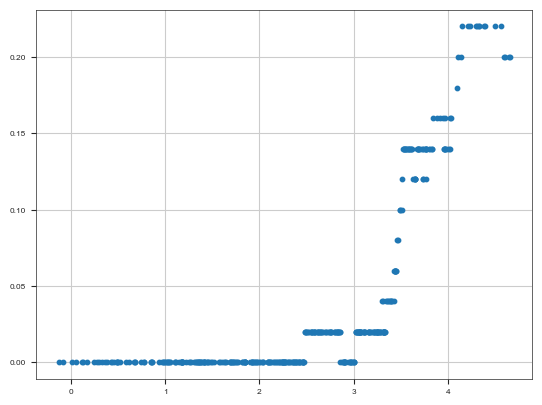

In [75]:
import numpy as np

def calculate_proportion(df, window_size):
    df_sorted = df.sort_values(by='logp')
    df_sorted['prop'] = df_sorted['y'].rolling(window=window_size, min_periods=1).mean()
    return df_sorted

dp = calculate_proportion(d, 50)
plt.scatter(dp["logp"], dp["prop"])

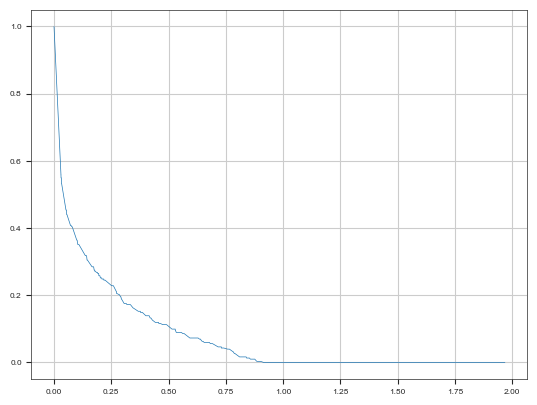

In [20]:
plt.plot(_, fpr)

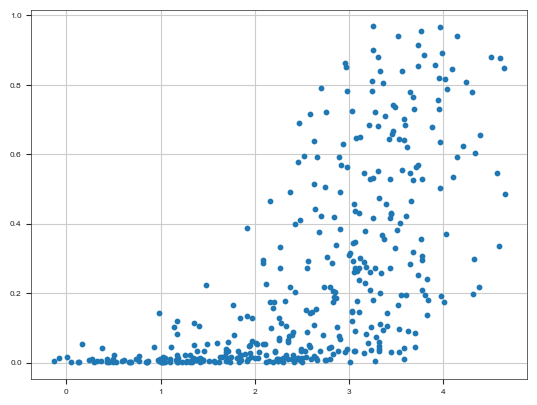

In [19]:
plt.scatter(d["logp"], d["y_hat"])